## Object counting and instance segmentation with image-level supervision
### Demo: Object counting in COCO Dataset

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from nest import modules, run_tasks
import matplotlib.pyplot as plt
import random
import xml.etree.ElementTree as ET
from collections import OrderedDict
from PIL import Image
import cv2
from scipy.misc import imresize
from pycocotools.coco import COCO
from termcolor import colored

### Counting evaluation functions

In [2]:
### Counting evaluation functions
def mrmse(non_zero,count_pred, count_gt):
    ## compute mrmse
    nzero_mask=torch.ones(count_gt.size())
    if non_zero==1:
        nzero_mask=torch.zeros(count_gt.size())
        nzero_mask[count_gt!=0]=1
    mrmse=torch.pow(count_pred - count_gt, 2)
    mrmse = torch.mul(mrmse, nzero_mask)
    mrmse = torch.sum(mrmse, 0)
    nzero = torch.sum(nzero_mask, 0)
    mrmse = torch.div(mrmse, nzero)
    mrmse = torch.sqrt(mrmse)
    mrmse = torch.mean(mrmse)
    return mrmse

def rel_mrmse(non_zero,count_pred, count_gt):
    ## compute reltive mrmse
    nzero_mask=torch.ones(count_gt.size())
    if non_zero==1:
        nzero_mask=torch.zeros(count_gt.size())
        nzero_mask[count_gt!=0]=1
    num = torch.pow(count_pred - count_gt, 2)
    denom = count_gt.clone()
    denom = denom+1
    rel_mrmse = torch.div(num, denom)
    rel_mrmse = torch.mul(rel_mrmse, nzero_mask)
    rel_mrmse = torch.sum(rel_mrmse, 0)
    nzero = torch.sum(nzero_mask, 0)
    rel_mrmse = torch.div(rel_mrmse, nzero)
    rel_mrmse = torch.sqrt(rel_mrmse)
    rel_mrmse = torch.mean(rel_mrmse)
    return rel_mrmse

### Inference setup

In [3]:
# object categories
coco_path='/raid/xiaoke/MSCOCO/coco'
cocoGt=COCO(coco_path+'/annotations/instances_val2014.json')
image_ids=cocoGt.getImgIds()

catids=cocoGt.getCatIds()
cats = cocoGt.loadCats(catids)
nms=[cat['name'] for cat in cats]

# image pre-processor
image_size = 448
transformer = modules.image_transform(
    image_size = [image_size, image_size],
    augmentation = dict(),
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])

loading annotations into memory...
Done (t=4.29s)
creating index...
index created!


### Load model weights

In [4]:
backbone = modules.fc_resnet50(channels=240, pretrained=False)
model = modules.peak_response_mapping(backbone,enable_peak_stimulation=True,peak_stimulation='addedmodule5',
                                     sub_pixel_locating_factor=1)
# loaded pre-trained weights
model = nn.DataParallel(model)
state = torch.load('../models/counting/coco14.pt')
model.load_state_dict(state['model'])
model = model.module.cuda()

<function PeakResponseMapping._median_filter at 0x7fb09d181bf8>
addedmodule5
enable_peak_stimulation on


### Load demo images from COCO dataset

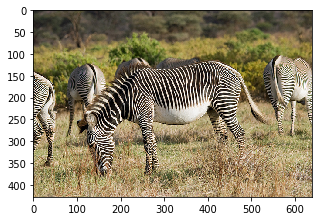

In [39]:
# change the idx to test different samples

idx = 0
raw_img = Image.open('./images/coco/sample%d.jpg'% idx).convert('RGB')
input_var = transformer(raw_img).unsqueeze(0).cuda().requires_grad_()
# plot raw image
plt.figure(figsize=(5,5))
plt.imshow(raw_img)

In [40]:
## predict count
model = model.eval()
confidence,density_map,_ = model(input_var,1)
count_den = F.adaptive_avg_pool2d(density_map, 1).squeeze(2).squeeze(2).detach().cpu().numpy()[0]
density_map=density_map.squeeze().detach().cpu().numpy()
confidence=confidence.cpu().detach().numpy()
confidence[confidence<0]=0
confidence=confidence[0]
confidence[confidence>0]=1
count=np.round(confidence*count_den)

print('***************************')
print('Object count in the image:')
for index in range(len(nms)):
    if count[index]:
        print(colored('    [class_idx: %d] %s (%.2f)' % (index, nms[index], count[index]), 'blue'))


***************************
Object count in the image:
    [class_idx: 22] zebra (6.00)
